### Imports and Data Loading

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. Load the SOTA features
df = pd.read_parquet("../data/EURUSD_H1_SOTA_Features.parquet")

# 2. Define Features and Target
target_col = 'label'
# We drop the regression target for this specific classification test
X_raw = df.drop(columns=[target_col, 'target_next_return'])
y_raw = df[target_col] + 1  # Encode [-1, 0, 1] to [0, 1, 2]

print(f"✅ Loaded {len(df)} rows with {X_raw.shape[1]} features.")

✅ Loaded 37121 rows with 13 features.


### Feature Engineering for Tabular Boosting

In [8]:
WINDOW_SIZE = 24

def create_flattened_sequences(data, target, window_size):
    # Scale first so the flattened rows are normalized
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    
    X_flat, y = [], []
    for i in range(len(scaled_data) - window_size):
        # Flatten the (24, 13) window into a (312,) vector
        window = scaled_data[i:(i + window_size)].flatten()
        X_flat.append(window)
        y.append(target.iloc[i + window_size])
        
    return np.array(X_flat), np.array(y)

X_boost, y_boost = create_flattened_sequences(X_raw, y_raw, WINDOW_SIZE)

# Time-series split (No shuffling!)
split = int(len(X_boost) * 0.8)
X_train, X_test = X_boost[:split], X_boost[split:]
y_train, y_test = y_boost[:split], y_boost[split:]

print(f"📊 XGBoost Input Shape: {X_train.shape}") # Should be (Samples, 24 * Features)

📊 XGBoost Input Shape: (29677, 312)


### Training the XGBoost Classifier

In [9]:
import xgboost as xgb

# --- Robust GPU Check ---
# Check if the installed version of XGBoost was built with CUDA support
can_use_gpu = xgb.build_info().get('USE_CUDA', False) == 'True'
device_type = "cuda" if can_use_gpu else "cpu"

print(f"🖥️ Using Device: {device_type.upper()}")

# Initialize the model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    objective='multi:softprob',
    num_class=3,
    tree_method='hist',   # Use 'hist' for both CPU and GPU in modern XGBoost
    device=device_type,   # Set to 'cuda' or 'cpu' dynamically
    early_stopping_rounds=15,
    random_state=42
)

# Train the model as before
print("🌲 Training XGBoost...")

🖥️ Using Device: CPU
🌲 Training XGBoost...


In [11]:
# Train with evaluation set to monitor overfitting
print("🌲 Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# Save the model
import os
os.makedirs('../models', exist_ok=True)
xgb_model.save_model("../models/best_xgboost_model.json")
print("✨ Model saved to ../models/best_xgboost_model.json")

🌲 Training XGBoost...
[0]	validation_0-mlogloss:1.07462
[10]	validation_0-mlogloss:0.99122
[20]	validation_0-mlogloss:0.95588
[30]	validation_0-mlogloss:0.94196
[40]	validation_0-mlogloss:0.93735
[50]	validation_0-mlogloss:0.93708
[60]	validation_0-mlogloss:0.93781
[61]	validation_0-mlogloss:0.93796
✨ Model saved to ../models/best_xgboost_model.json


### Analysis and Performance Metrics


--- 📊 XGBOOST CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Sell       0.41      0.36      0.38      2061
        Hold       0.65      0.79      0.72      3120
         Buy       0.45      0.37      0.41      2239

    accuracy                           0.55      7420
   macro avg       0.51      0.51      0.50      7420
weighted avg       0.53      0.55      0.53      7420



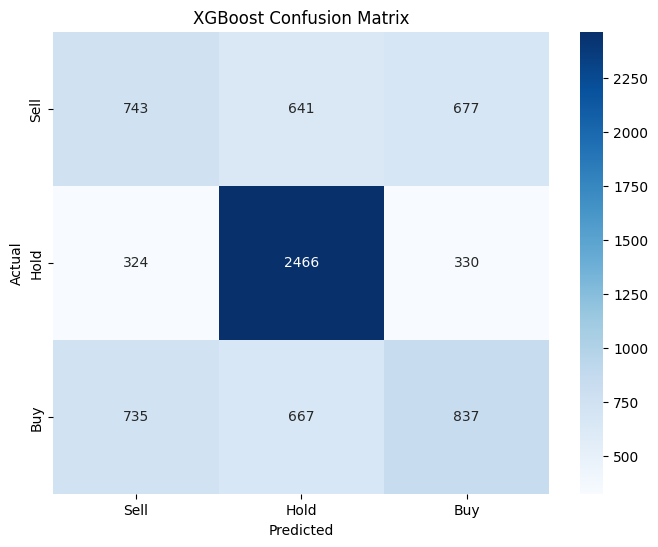

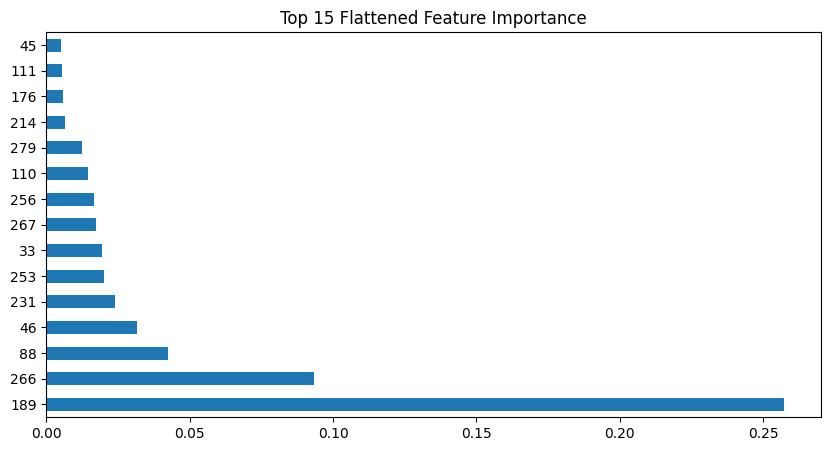

In [12]:
# Predictions
y_pred = xgb_model.predict(X_test)

# 1. Classification Report
print("\n--- 📊 XGBOOST CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Sell', 'Hold', 'Buy']))

# 2. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell', 'Hold', 'Buy'], 
            yticklabels=['Sell', 'Hold', 'Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# 3. Feature Importance (Top 10 flattened features)
# Note: Feature 0 might be 'log_ret' 24 hours ago
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(xgb_model.feature_importances_)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Flattened Feature Importance")
plt.show()

In [1]:
import pandas as pd
import pandas_ta as ta  # Ensure you have this: pip install pandas_ta

# 1. LOAD H1 DATA
print("🔄 Loading H1 Data...")
# We load the original file. Assuming it still has raw OHLC columns.
# If your SOTA_Features file dropped the raw columns, load your ORIGINAL raw H1 csv/parquet.
df_h1 = pd.read_parquet("../data/EURUSD_H1_SOTA_Features.parquet")

# Ensure index is Datetime (Crucial for resampling)
if not isinstance(df_h1.index, pd.DatetimeIndex):
    # Try to find the date column if index isn't set
    if 'date' in df_h1.columns:
        df_h1['date'] = pd.to_datetime(df_h1['date'])
        df_h1.set_index('date', inplace=True)
    elif 'time' in df_h1.columns:
        df_h1['time'] = pd.to_datetime(df_h1['time'])
        df_h1.set_index('time', inplace=True)

# 2. RESAMPLE TO H4 (The Correct Way)
# Logic:
# - Open  = Open of the 1st hour
# - High  = Max High of the 4 hours
# - Low   = Min Low of the 4 hours
# - Close = Close of the 4th hour
# - Volume = Sum of Volume over 4 hours

aggregation = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    # If you have volume, uncomment below:
    # 'tick_volume': 'sum' 
}

# Resample to 4 Hours
print("🔨 Aggregating to H4 Candles...")
df_h4 = df_h1.resample('4H').agg(aggregation)

# Drop incomplete rows (e.g., if data ends at 2:00 PM, the last 4H bar is unfinished)
df_h4 = df_h4.dropna()

print(f"📉 Rows: {len(df_h1)} (H1) -> {len(df_h4)} (H4)")

# 3. RE-ENGINEER FEATURES ON H4 DATA
# We cannot use the old H1 features (like 'rsi_z') because RSI(H4) != Average(RSI_H1)
# We must calculate fresh indicators on the new H4 candles.

print("🧪 Re-calculating Indicators on H4...")

# A. Moving Averages (Trend)
df_h4['sma20'] = ta.sma(df_h4['close'], length=20)
df_h4['sma50'] = ta.sma(df_h4['close'], length=50)

# Distance Features (The "Rubber Band")
df_h4['dist_sma20'] = df_h4['close'] - df_h4['sma20']
df_h4['dist_sma50'] = df_h4['close'] - df_h4['sma50']

# B. RSI (Momentum)
df_h4['rsi'] = ta.rsi(df_h4['close'], length=14)
# Z-Score the RSI to make it stationary
df_h4['rsi_z'] = (df_h4['rsi'] - df_h4['rsi'].rolling(200).mean()) / df_h4['rsi'].rolling(200).std()

# C. Volatility (Bollinger Band Width)
bb = ta.bbands(df_h4['close'], length=20, std=2)
df_h4['bb_width'] = (bb['BBU_20_2.0'] - bb['BBL_20_2.0']) / df_h4['sma20']

# D. Time Embeddings (Context)
# We need to extract hour/day from the H4 timestamp
df_h4['hour'] = df_h4.index.hour
df_h4['day_of_week'] = df_h4.index.dayofweek
df_h4['hour_sin'] = np.sin(2 * np.pi * df_h4['hour'] / 24)
df_h4['hour_cos'] = np.cos(2 * np.pi * df_h4['hour'] / 24)

# E. Log Returns (Target Basis)
df_h4['log_ret'] = np.log(df_h4['close'] / df_h4['close'].shift(1))

# Drop NaNs created by indicators (first 50 rows)
df_h4 = df_h4.dropna()

print("✅ H4 Dataset Ready.")
print(df_h4[['close', 'dist_sma50', 'rsi_z']].tail())

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.4.